In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

from scipy.special import expit

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import loguniform, uniform

from sklearn.decomposition import PCA

In [2]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
df_train=pd.read_csv("../ravdess_features_train_pulito.csv") #377 variabili
df_test=pd.read_csv("../ravdess_features_test_pulito.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])

### Outlier dropping

In [4]:
#df_train.drop(axis="index", labels=[35,243,451,554,563,658,659,1031,1075,1283], inplace=True)
X_train=df_train.drop(columns=["sex"]).values
y_train=df_train.sex.values

#df_test.drop(axis="index", labels=[33,34,138,196,197,198,199], inplace=True)
X_test=df_test.drop(columns=["sex"]).values
y_test=df_test.sex.values

### Feature selection (da implementare)

In [5]:
sel = SelectKBest(k=108)
X_train_sel = sel.fit_transform(X_train, y_train)
X_test_sel = sel.transform(X_test)

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Scaling

In [6]:
scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

In [7]:
X_train

array([[-0.83222148,  0.32721511, -0.92613367, ...,  0.69019212,
         9.40036023, -3.03500471],
       [-0.83222148,  0.32721511, -0.92613367, ...,  0.40975354,
        -0.1865042 ,  0.43453832],
       [-0.83222148,  0.32721511, -0.92613367, ...,  0.72285412,
         2.8913017 , -1.46375423],
       ...,
       [-0.83222148, -0.10248979,  1.07975774, ...,  0.62460468,
        -0.13009999, -0.4542434 ],
       [-0.83222148, -0.10248979,  1.07975774, ...,  0.34378024,
         0.07291733, -1.05856439],
       [-0.83222148, -0.10248979,  1.07975774, ...,  0.17821988,
        -0.52466101,  0.26155608]])

In [8]:
clf = LinearSVC(C=1.0, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9599358974358975
F1-score [0.96       0.95987159]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       312
           1       0.96      0.96      0.96       312

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624



# PCA

In [9]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

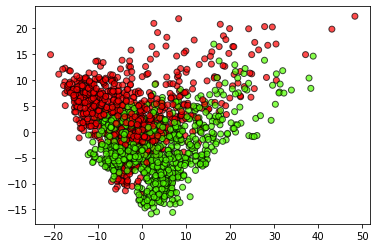

In [10]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# LinearSVC

### Tuning hyperparameter

In [11]:
def get_models_unweighted():
    models = dict()
    for p in [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5, 1]:
        models[p] = LinearSVC(multi_class='ovr', C=p, class_weight=None)
    return models

def get_models_weighted():
    models = dict()
    for p in [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5, 1]:
        models[p] = LinearSVC(multi_class='ovr', C=p, class_weight="balanced")
    return models

def evaluate_model_accuracy(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

def evaluate_model_f1(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    return scores

In [12]:
'''
models = get_models_unweighted()
accuracy, f1, names = list(), list(), list()
for name, model in models.items():
	accuracy_scores = evaluate_model_accuracy(model, X_train, y_train)
	f1_scores = evaluate_model_f1(model, X_train, y_train)
	accuracy.append(accuracy_scores)
	f1.append(f1_scores)
	names.append(name)
	print(name)
	print('Accuracy:\t %.3f (%.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
	print('f1:\t %.3f (%.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
# Tempo stimato 4.30m
'''

"\nmodels = get_models_unweighted()\naccuracy, f1, names = list(), list(), list()\nfor name, model in models.items():\n\taccuracy_scores = evaluate_model_accuracy(model, X_train, y_train)\n\tf1_scores = evaluate_model_f1(model, X_train, y_train)\n\taccuracy.append(accuracy_scores)\n\tf1.append(f1_scores)\n\tnames.append(name)\n\tprint(name)\n\tprint('Accuracy:\t %.3f (%.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))\n\tprint('f1:\t %.3f (%.3f)' % (np.mean(f1_scores), np.std(f1_scores)))\n# Tempo stimato 4.30m\n"

In [13]:
'''
models = get_models_weighted()
accuracy, f1, names = list(), list(), list()
for name, model in models.items():
	accuracy_scores = evaluate_model_accuracy(model, X_train, y_train)
	f1_scores = evaluate_model_f1(model, X_train, y_train)
	accuracy.append(accuracy_scores)
	f1.append(f1_scores)
	names.append(name)
	print(name)
	print('Accuracy:\t %.3f (%.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
	print('f1:\t %.3f (%.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
	print("\n")

# Tempo stimato 4.30m
'''

'\nmodels = get_models_weighted()\naccuracy, f1, names = list(), list(), list()\nfor name, model in models.items():\n\taccuracy_scores = evaluate_model_accuracy(model, X_train, y_train)\n\tf1_scores = evaluate_model_f1(model, X_train, y_train)\n\taccuracy.append(accuracy_scores)\n\tf1.append(f1_scores)\n\tnames.append(name)\n\tprint(name)\n\tprint(\'Accuracy:\t %.3f (%.3f)\' % (np.mean(accuracy_scores), np.std(accuracy_scores)))\n\tprint(\'f1:\t %.3f (%.3f)\' % (np.mean(f1_scores), np.std(f1_scores)))\n\tprint("\n")\n\n# Tempo stimato 4.30m\n'

Migliore risultato C=0.05, class_weight="balanced"

In [14]:
clf = LinearSVC(C=0.05, class_weight="balanced", max_iter=10000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9551282051282052
F1-score [0.95498392 0.95527157]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       312
           1       0.95      0.96      0.96       312

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624



nel caso rimuovi le prossime celle fino a NonLInearSVM

In [15]:
X_train.shape

(1828, 376)

In [16]:
decision_function = clf.decision_function(X_train)

In [17]:
decision_function

array([-0.91684632, -2.71984854, -5.14902055, ...,  3.03998139,
        1.93910829,  1.07126632])

In [18]:

support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]

In [19]:
support_vectors_pca = pca.transform(support_vectors)

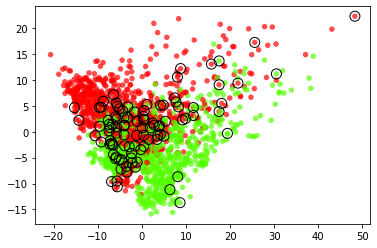

In [20]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

## Nonlinear SVM

In [21]:
'''
param_grid = {
    "C": [1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "coef0": [1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    "gamma": ["scale", "auto"]
}
grid = RandomizedSearchCV(
    SVC(class_weight="balanced", max_iter=-1),
    param_distributions=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    n_iter=500,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
'''
# tempo impiegato circa 34 minuti

'\nparam_grid = {\n    "C": [1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],\n    "kernel": ["linear", "poly", "rbf", "sigmoid"],\n    "coef0": [1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1],\n    "gamma": ["scale", "auto"]\n}\ngrid = RandomizedSearchCV(\n    SVC(class_weight="balanced", max_iter=-1),\n    param_distributions=param_grid,\n    scoring="accuracy",\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    n_iter=500,\n)\ngrid.fit(X_train, y_train)\nclf = grid.best_estimator_\n'

In [22]:
#grid.best_estimator_

In [23]:
#SVC(C=0.95, class_weight='balanced', coef0=1, kernel='poly') 

In [24]:
clf = SVC(C=0.95, class_weight='balanced', coef0=1, gamma='auto', kernel='poly', degree=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9519230769230769
F1-score [0.95145631 0.95238095]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       312
           1       0.94      0.96      0.95       312

    accuracy                           0.95       624
   macro avg       0.95      0.95      0.95       624
weighted avg       0.95      0.95      0.95       624



Best params: C=0.75, class_weight='balanced', coef0=1, gamma='auto', kernel='poly'.

Non convince il coef0. Faccio GridSearchCV su quest'ultimo.

In [25]:
clf = SVC(C=0.75, class_weight='balanced', coef0=1, gamma='auto', kernel='poly', degree=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9487179487179487
F1-score [0.94805195 0.94936709]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       312
           1       0.94      0.96      0.95       312

    accuracy                           0.95       624
   macro avg       0.95      0.95      0.95       624
weighted avg       0.95      0.95      0.95       624



In [26]:
clf = SVC(C=0.75, class_weight='balanced', coef0=1, gamma='auto', kernel='poly', degree=3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9439102564102564
F1-score [0.94327391 0.94453249]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       312
           1       0.93      0.96      0.94       312

    accuracy                           0.94       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624



### GridSearchCV su coef0 e C

In [27]:
'''
param_grid = {
    "coef0": np.linspace(0,2,num=50),
    "C": np.linspace(1e-16,1,num=25),
}
grid = GridSearchCV(
    SVC(gamma="auto", kernel="poly", class_weight="balanced", max_iter=-1),
    param_grid=param_grid,
    scoring="accuracy",
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
'''
# tempo stimato circa 220 minuti

'\nparam_grid = {\n    "coef0": np.linspace(0,2,num=50),\n    "C": np.linspace(1e-16,1,num=25),\n}\ngrid = GridSearchCV(\n    SVC(gamma="auto", kernel="poly", class_weight="balanced", max_iter=-1),\n    param_grid=param_grid,\n    scoring="accuracy",\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n)\ngrid.fit(X_train, y_train)\nclf = grid.best_estimator_\n'

In [28]:
#grid.best_params_

coef0=2 risulta il migliore

In [29]:
'''
clf = SVC(C=1, class_weight='balanced', coef0=2, gamma='auto', kernel='poly', degree=2, max_iter=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
'''

"\nclf = SVC(C=1, class_weight='balanced', coef0=2, gamma='auto', kernel='poly', degree=2, max_iter=-1)\nclf.fit(X_train, y_train)\n\ny_pred = clf.predict(X_test)\n\nprint('Accuracy %s' % accuracy_score(y_test, y_pred))\nprint('F1-score %s' % f1_score(y_test, y_pred, average=None))\nprint(classification_report(y_test, y_pred))\n"

In [30]:
clf = SVC(C=0.6, class_weight='balanced', coef0=1, gamma='auto', kernel='poly', degree=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9487179487179487
F1-score [0.94771242 0.94968553]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       312
           1       0.93      0.97      0.95       312

    accuracy                           0.95       624
   macro avg       0.95      0.95      0.95       624
weighted avg       0.95      0.95      0.95       624



In [31]:
support_vectors_pca = pca.transform(clf.support_vectors_) #[:10]

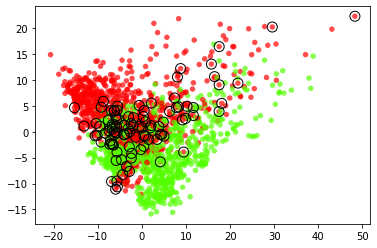

In [32]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [33]:
valC = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
Acc = []
for i in valC:
    clf = SVC(C=i, class_weight='balanced', coef0=1, gamma='auto', kernel='poly', degree=2)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    Acc.append(accuracy_score(y_test, y_pred))
    #('Accuracy %s' % accuracy_score(y_test, y_pred))
    
    
    '''
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin)
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))
   

plt.plot(np.arange(2, max_supp), valC, label="Accuracy")
#plt.plot(np.arange(2, max_supp), len_cl_it, label="closed")
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("itemsets")

plt.show()
 '''
print(Acc)
print(valC)

[0.9487179487179487, 0.9487179487179487, 0.9487179487179487, 0.9487179487179487, 0.9471153846153846, 0.9487179487179487, 0.9503205128205128, 0.9519230769230769, 0.9519230769230769, 0.9519230769230769]
[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


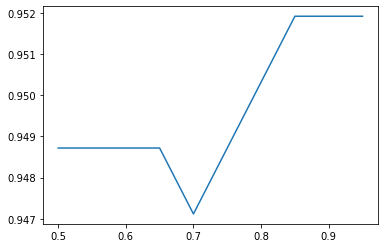

In [34]:
plt.plot(valC, Acc)

## Effect of different kernels

In [35]:
#from sklearn.datasets import load_iris

#iris = load_iris()
X = X_train
y = y_train

X = X[y != 0, :2]
y = y[y != 0]

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

# fit the model
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_6430/716007104.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = y[order].astype(np.float)


ValueError: The number of classes has to be greater than one; got 1 class